- 5,6만 분류하는 모델 만들기
- randomforest / SmoteTomek 이용 결정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

# Class Imbalance import
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

In [2]:
# Seed 고정
seed = 1
np.random.seed(seed)

In [41]:
# 원본 데이터 준비

df_org = pd.read_csv('data/mulit_classification_data.csv')
df_org.shape

(1941, 34)

In [42]:
encoding_list = ['TypeOfSteel_A300', 'TypeOfSteel_A400']

# 오디날 인코딩 수행
df_org['Type_of_Steel'] = df_org[encoding_list].idxmax(axis=1).apply(lambda x: encoding_list.index(x))

# 오디날 인코딩된 컬럼 삭제
df_org = df_org.drop(encoding_list, axis=1)

# 결과 출력
print(df_org['Type_of_Steel'])

0       0
1       0
2       0
3       1
4       1
       ..
1936    1
1937    1
1938    1
1939    1
1940    0
Name: Type_of_Steel, Length: 1941, dtype: int64


In [43]:
target_list = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# 오디날 인코딩 수행
df_org['Target'] = df_org[target_list].idxmax(axis=1).apply(lambda x: target_list.index(x))

# 오디날 인코딩된 컬럼 삭제
df_org = df_org.drop(target_list, axis=1)

# 결과 출력
print(df_org['Target'])

0       0
1       0
2       0
3       0
4       0
       ..
1936    6
1937    6
1938    6
1939    6
1940    6
Name: Target, Length: 1941, dtype: int64


In [44]:
# Index / log 컬럼 삭제 데이터 준비
df_org.columns[12:25]

Index(['Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas'],
      dtype='object')

In [45]:
columns_to_drop = [i for i in range(12, 25)]
df_sel_org = df_org.drop(columns=df_org.columns[columns_to_drop])
df_sel_org

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Type_of_Steel,Target
0,42,50,270900,270944,267,17,44,24220,76,108,1687,80,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,80,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,100,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,290,1,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,185,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,1360,40,1,6
1937,144,175,340581,340598,287,44,24,34599,112,133,1360,40,1,6
1938,145,174,386779,386794,292,40,22,37572,120,140,1360,40,1,6
1939,137,170,422497,422528,419,97,47,52715,117,140,1360,40,1,6


In [46]:
# 'Target' 컬럼이 5 또는 6인 행만 추출
df = df_org[(df_org['Target'] == 5) | (df_org['Target'] == 6)]
df_selected = df_sel_org[(df_sel_org['Target'] == 5) | (df_sel_org['Target'] == 6)]


In [47]:
df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Type_of_Steel,Target
866,38,49,735612,735624,113,11,12,12652,93,130,...,1.0000,1.0,2.0531,1.0414,1.0792,0.0833,-0.1253,0.2432,0,5
867,1252,1348,355940,356016,1812,119,135,196003,82,132,...,0.5630,0.0,3.2582,1.9823,1.8808,-0.2083,-0.1549,1.0000,0,5
868,1095,1102,3028545,3028556,41,8,11,4533,100,123,...,1.0000,1.0,1.6128,0.8451,1.0414,0.3636,-0.1362,0.1822,0,5
869,193,210,612201,612252,588,18,51,62182,73,135,...,1.0000,1.0,2.7694,1.2305,1.7076,0.6667,-0.1738,0.9774,1,5
870,1159,1170,32914,32926,106,11,12,12792,100,134,...,1.0000,1.0,2.0253,1.0414,1.0792,0.0833,-0.0572,0.2432,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254,1,6
1937,144,175,340581,340598,287,44,24,34599,112,133,...,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173,1,6
1938,145,174,386779,386794,292,40,22,37572,120,140,...,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079,1,6
1939,137,170,422497,422528,419,97,47,52715,117,140,...,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919,1,6


In [48]:
df_selected

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Type_of_Steel,Target
866,38,49,735612,735624,113,11,12,12652,93,130,1707,100,0,5
867,1252,1348,355940,356016,1812,119,135,196003,82,132,1687,80,0,5
868,1095,1102,3028545,3028556,41,8,11,4533,100,123,1467,120,0,5
869,193,210,612201,612252,588,18,51,62182,73,135,1353,290,1,5
870,1159,1170,32914,32926,106,11,12,12792,100,134,1353,185,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,1360,40,1,6
1937,144,175,340581,340598,287,44,24,34599,112,133,1360,40,1,6
1938,145,174,386779,386794,292,40,22,37572,120,140,1360,40,1,6
1939,137,170,422497,422528,419,97,47,52715,117,140,1360,40,1,6


In [49]:
# 'Target' 컬럼 값이 5면 0으로, 6이면 1로 바꿔주기
df['Target'] = df['Target'].replace({5: 0, 6: 1})
df_selected['Target'] = df_selected['Target'].replace({5: 0, 6: 1})

C:\Users\PSY\AppData\Local\Temp\ipykernel_11956\3411397896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = df['Target'].replace({5: 0, 6: 1})
C:\Users\PSY\AppData\Local\Temp\ipykernel_11956\3411397896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Target'] = df_selected['Target'].replace({5: 0, 6: 1})


In [50]:
# 행들을 뒤죽박죽으로 섞기
df = df.sample(frac=1, random_state=42)
df_selected = df_selected.sample(frac=1, random_state=42)

### 데이터셋 분리 (train / val / test)

In [51]:
# target / feature 분리

target = 'Target'

x_org = df.drop(target, axis=1)
y_org = df[target]

x_sel = df_selected.drop(target, axis=1)
y_sel = df_selected[target]

In [52]:
## 데이터셋 분리 (train / val / test)

print('--------------------<원본 데이터셋>')

x_train, x_test, y_train, y_test = train_test_split(x_org, y_org, test_size=0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print(f'train data : x{x_train.shape}, y{y_train.shape}')
print(f'val data : x{x_val.shape}, y{y_val.shape}')
print(f'test data : x{x_test.shape}, y{y_test.shape}')


print()
print('--------------------<col selected 데이터셋>')

x_train_sel, x_test_sel, y_train_sel, y_test_sel = train_test_split(x_sel, y_sel, test_size=0.1, random_state=1)
x_train_sel, x_val_sel, y_train_sel, y_val_sel = train_test_split(x_train_sel, y_train_sel, test_size=0.1, random_state=1)

print(f'train data : x{x_train_sel.shape}, y{y_train_sel.shape}')
print(f'val data : x{x_val_sel.shape}, y{y_val_sel.shape}')
print(f'test data : x{x_test_sel.shape}, y{y_test_sel.shape}')


--------------------<원본 데이터셋>
train data : x(870, 26), y(870,)
val data : x(97, 26), y(97,)
test data : x(108, 26), y(108,)

--------------------<col selected 데이터셋>
train data : x(870, 13), y(870,)
val data : x(97, 13), y(97,)
test data : x(108, 13), y(108,)


## Model 선택 (df data)

In [60]:
# 손실값 계산 함수 (수정 중)
def compute_loss(y_true, y_pred):
    M = len(y_true)
    N = 1 if isinstance(y_pred, (int, float)) else np.array(y_pred).shape[1]
    square_sum = np.sum(np.square(y_true - np.array(y_pred)))
    loss = square_sum / (M * N)
    
    return loss

# 정확도 반환 함수
def eval_models(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    
    return accuracy

In [61]:
def train_val_score(model):
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)

    model_eval = pd.DataFrame(index=['Accuracy', 'Loss'], columns=['Train', 'Val'])
    model_eval['Train'] = eval_models(y_train, y_train_pred)
    model_eval['Val'] = eval_models(y_val, y_val_pred)
    
    display(model_eval)
    return model_eval

In [62]:
# 기준모델
base = y_train.mode()[0]
baseline = [base] * len(y_train)

# 모델별 score
eval_table = pd.DataFrame(index=['Accuracy'], 
                          columns=['Baseline', 'Logistic', 'KNN', 'naivebayes', 'DecisionTree', 'RandomForest', 'XGB'])
eval_table['Baseline'] = eval_models(y_train, baseline)
eval_table

,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# LogisticRegression

logistic = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    LogisticRegression(random_state = 1))

logistic.fit(x_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[])),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=1))])

In [64]:
# train-val score
train_val_score(logistic)

# 모델별 score
y_val_pred = logistic.predict(x_val)
eval_table['Logistic'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.758621,0.701031
Loss,0.758621,0.701031


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.701031,NaN,NaN,NaN,NaN,NaN


In [65]:
# KNN

knn = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))

knn.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [66]:
# train-val score
train_val_score(knn)

# 모델별 score
y_val_pred = knn.predict(x_val)
eval_table['KNN'] = eval_models(y_val, y_val_pred)
eval_table

c:\Users\PSY\anaconda3\envs\teamproject1\lib\site-packages\joblib\externals\loky\backend\context.py:130: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\PSY\anaconda3\envs\teamproject1\lib\site-packages\joblib\externals\loky\backend\context.py", line 251, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\PSY\anaconda3\envs\teamproject1\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\PSY\anaconda3\envs\teamproject1\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\PSY\anaconda3\envs\teamproject1\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executab

,Train,Val
Accuracy,0.822989,0.71134
Loss,0.822989,0.71134


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.701031,0.71134,NaN,NaN,NaN,NaN


In [67]:
# naivebayes

nb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    GaussianNB())

nb.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [68]:
# train-val score
train_val_score(nb)

# 모델별 score
y_val_pred = nb.predict(x_val)
eval_table['naivebayes'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.57931,0.618557
Loss,0.57931,0.618557


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.701031,0.71134,0.618557,NaN,NaN,NaN


In [69]:
# DecisionTreeClassifier

decisiontree = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state = 1))

decisiontree.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=1))])

In [70]:
# train-val score
train_val_score(decisiontree)

# 모델별 score
y_val_pred = decisiontree.predict(x_val)
eval_table['DecisionTree'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,1.0,0.742268
Loss,1.0,0.742268


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.701031,0.71134,0.618557,0.742268,NaN,NaN


In [71]:
# RandomForestClassifier

randomforest = RandomForestClassifier(random_state = 1)

randomforest.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

In [72]:
# train-val score
train_val_score(randomforest)

# 모델별 score
y_val_pred = randomforest.predict(x_val)
eval_table['RandomForest'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,1.0,0.783505
Loss,1.0,0.783505


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.701031,0.71134,0.618557,0.742268,0.783505,NaN


In [73]:
xgb = XGBClassifier()

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [74]:
# train-val score
train_val_score(xgb)

# 모델별 score
y_val_pred = xgb.predict(x_val)
eval_table['XGB'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,1.0,0.742268
Loss,1.0,0.742268


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.701031,0.71134,0.618557,0.742268,0.783505,0.742268


## Model 선택 (df_selected data)

In [81]:
x_train = x_train_sel
y_train = y_train_sel
x_val = x_val_sel
y_val = y_val_sel
x_test = x_test_sel
y_test = y_test_sel

In [82]:
# 기준모델
base = y_train.mode()[0]
baseline = [base] * len(y_train)

# 모델별 score
eval_table = pd.DataFrame(index=['Accuracy'], 
                          columns=['Baseline', 'Logistic', 'KNN', 'naivebayes', 'DecisionTree', 'RandomForest', 'XGB'])
eval_table['Baseline'] = eval_models(y_train, baseline)
eval_table

,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# LogisticRegression

logistic = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    LogisticRegression(random_state = 1))

logistic.fit(x_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[])),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=1))])

In [84]:
# train-val score
train_val_score(logistic)

# 모델별 score
y_val_pred = logistic.predict(x_val)
eval_table['Logistic'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.695402,0.742268
Loss,0.695402,0.742268


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.742268,NaN,NaN,NaN,NaN,NaN


In [85]:
# KNN

knn = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))

knn.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [86]:
# train-val score
train_val_score(knn)

# 모델별 score
y_val_pred = knn.predict(x_val)
eval_table['KNN'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.828736,0.690722
Loss,0.828736,0.690722


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.742268,0.690722,NaN,NaN,NaN,NaN


In [87]:
# naivebayes

nb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    GaussianNB())

nb.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [88]:
# train-val score
train_val_score(nb)

# 모델별 score
y_val_pred = nb.predict(x_val)
eval_table['naivebayes'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.544828,0.56701
Loss,0.544828,0.56701


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.742268,0.690722,0.56701,NaN,NaN,NaN


In [89]:
# DecisionTreeClassifier

decisiontree = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state = 1))

decisiontree.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=1))])

In [90]:
# train-val score
train_val_score(decisiontree)

# 모델별 score
y_val_pred = decisiontree.predict(x_val)
eval_table['DecisionTree'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,1.0,0.762887
Loss,1.0,0.762887


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.742268,0.690722,0.56701,0.762887,NaN,NaN


In [91]:
# RandomForestClassifier

randomforest = RandomForestClassifier(random_state = 1)

randomforest.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

In [92]:
# train-val score
train_val_score(randomforest)

# 모델별 score
y_val_pred = randomforest.predict(x_val)
eval_table['RandomForest'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,1.0,0.835052
Loss,1.0,0.835052


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.742268,0.690722,0.56701,0.762887,0.835052,NaN


In [93]:
xgb = XGBClassifier()

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [94]:
# train-val score
train_val_score(xgb)

# 모델별 score
y_val_pred = xgb.predict(x_val)
eval_table['XGB'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,1.0,0.793814
Loss,1.0,0.793814


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.627586,0.742268,0.690722,0.56701,0.762887,0.835052,0.793814


Selected Data / RandomForest 또는 xgb로 결정

## Class Imbalance 해결

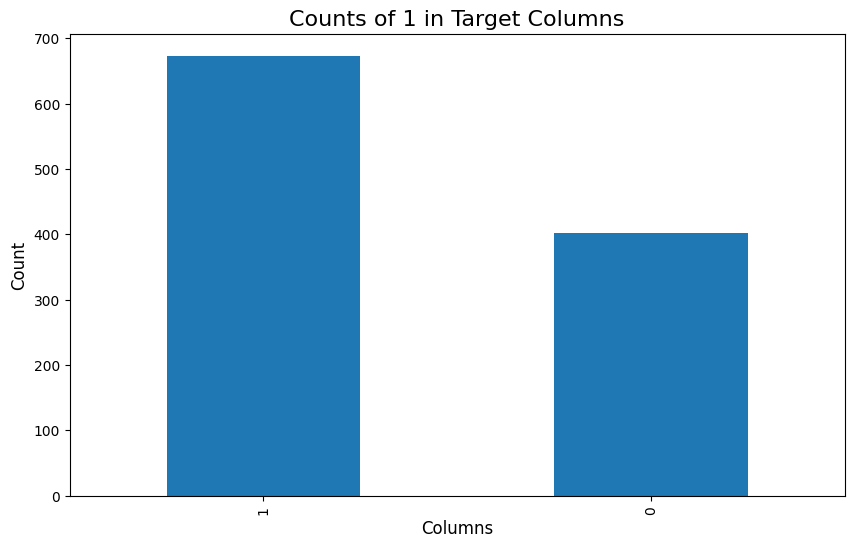

In [104]:
# target 분포 확인

# 컬럼별 1의 갯수 세기
counts = df_selected['Target'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
counts.plot(kind='bar')  # 막대 그래프로 시각화
plt.title("Counts of 1 in Target Columns", fontsize=16)  # 그래프 제목 설정
plt.xlabel("Columns", fontsize=12)  # x축 레이블 설정
plt.ylabel("Count", fontsize=12)  # y축 레이블 설정
plt.show()  # 그래프 출력


In [105]:
u_sampler = RandomUnderSampler(random_state=1)
x_train_u, y_train_u = u_sampler.fit_resample(x_train, y_train)

o_sampler = RandomOverSampler(random_state=1)
x_train_o, y_train_o = o_sampler.fit_resample(x_train, y_train)

smote = SMOTE(random_state=1)
x_train_s, y_train_s = smote.fit_resample(x_train, y_train)

In [106]:
def sampling_score(model):
    
    print(f'MODEL : {model}')
    
    x_samples = [x_train_u, x_train_o, x_train_s]
    y_samples = [y_train_u, y_train_o, y_train_s]
    sample_eval = pd.DataFrame(index=['Accuracy'], columns=['Under', 'Over', 'SMOTE'])
    
    for i, x, y in zip(range(3), x_samples, y_samples):
        model.fit(x, y)
        y_val_pred = model.predict(x_val)
        
        sample_eval[sample_eval.columns[i]] = eval_models(y_val, y_val_pred)

    return sample_eval

In [107]:
sampling_score(randomforest)


MODEL : RandomForestClassifier(random_state=1)


,Under,Over,SMOTE
Accuracy,0.762887,0.804124,0.814433


In [108]:
sampling_score(xgb)

MODEL : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


,Under,Over,SMOTE
Accuracy,0.773196,0.824742,0.793814


In [99]:
# 컨퓨전 리포트 출력
xgb.fit(x_train_o, y_train_o)
y_val_pred = xgb.predict(x_val)
report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        37
           1       0.86      0.85      0.86        60

    accuracy                           0.82        97
   macro avg       0.81      0.82      0.82        97
weighted avg       0.83      0.82      0.83        97



In [100]:
y_test_pred = xgb.predict(x_test)
report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.73      0.71        41
           1       0.83      0.81      0.82        67

    accuracy                           0.78       108
   macro avg       0.76      0.77      0.77       108
weighted avg       0.78      0.78      0.78       108



SMOTETomek 이용

In [109]:
from imblearn.combine import SMOTETomek

x_resampled, y_resampled = SMOTETomek().fit_resample(x_train, y_train) #데이터 증강
print(x_resampled.shape, y_resampled.shape)


(858, 13) (858,)


In [111]:
randomforest.fit(x_resampled, y_resampled)
y_val_pred = randomforest.predict(x_val)
report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.84      0.82        37
           1       0.90      0.87      0.88        60

    accuracy                           0.86        97
   macro avg       0.85      0.85      0.85        97
weighted avg       0.86      0.86      0.86        97



In [110]:
xgb.fit(x_resampled, y_resampled)
y_val_pred = xgb.predict(x_val)
report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.70      0.74        37
           1       0.83      0.88      0.85        60

    accuracy                           0.81        97
   macro avg       0.81      0.79      0.80        97
weighted avg       0.81      0.81      0.81        97



# 예측 확률 뽑아보기

In [97]:
def get_mismatched_indices(y_true, y_pred):
    mismatched_indices = np.where(y_true != y_pred)[0]
    return mismatched_indices.tolist()

def get_matched_indices(y_true, y_pred):
    mismatched_indices = np.where(y_true == y_pred)[0]
    return mismatched_indices.tolist()

# 다른 부분의 인덱스 추출
mismatched_indices = get_mismatched_indices(y_val, y_val_pred)
matched_indices = get_matched_indices(y_val, y_val_pred)

# 결과 확인
print("맞은 것:", matched_indices)
print("틀린 것:", mismatched_indices)


맞은 것: [0, 1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 179, 180, 181, 182, 185, 186, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 218, 219, 220, 222, 223, 225, 226, 227, 229, 230, 231, 232, 234, 235, 236, 237, 238, 239, 241, 242, 243, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260

In [98]:
predictions_proba = randomforest.predict_proba(x_val)
predictions_proba = pd.DataFrame(predictions_proba, columns=target_list)
predictions_proba

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.14,0.13,0.02,0.01,0.07,0.18,0.45
1,0.00,0.00,0.99,0.00,0.00,0.00,0.01
2,0.10,0.01,0.00,0.01,0.01,0.60,0.27
3,0.39,0.00,0.00,0.00,0.00,0.24,0.37
4,0.13,0.00,0.00,0.00,0.01,0.59,0.27
...,...,...,...,...,...,...,...
306,0.06,0.00,0.02,0.00,0.00,0.79,0.13
307,0.10,0.01,0.02,0.00,0.00,0.05,0.82
308,0.00,0.00,0.00,0.99,0.00,0.00,0.01
309,0.02,0.08,0.48,0.00,0.00,0.05,0.37


In [99]:
# 맞은 것들의 예측 확률 비교
max_values = predictions_proba.apply(lambda row: row.max(), axis=1)
max_values.iloc[matched_indices]

0      0.45
1      0.99
2      0.60
4      0.59
5      0.81
       ... 
305    0.55
307    0.82
308    0.99
309    0.48
310    0.82
Length: 262, dtype: float64

In [100]:
x_val = pd.DataFrame(x_val)
x_val.iloc[matched_indices].describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Empty_Index,Type_of_Steel
count,262.000000,262.000000,2.620000e+02,2.620000e+02,262.000000,262.000000,262.000000,2.620000e+02,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,569.480916,618.580153,1.523575e+06,1.523622e+06,2120.667939,120.896947,83.015267,2.393109e+05,83.087786,130.591603,1466.717557,82.709924,0.410732,0.610687
std,517.690019,491.029148,1.397627e+06,1.397621e+06,4419.584853,211.952050,131.819334,5.167560e+05,33.515764,20.210321,145.592239,58.222060,0.132428,0.488528
min,0.000000,6.000000,9.228000e+03,9.246000e+03,12.000000,4.000000,4.000000,1.537000e+03,7.000000,71.000000,1306.000000,40.000000,0.071400,0.000000
25%,53.250000,196.750000,4.843642e+05,4.844288e+05,87.500000,15.000000,13.000000,9.795500e+03,59.500000,124.000000,1358.000000,40.000000,0.320200,0.000000
50%,442.000000,492.000000,1.127812e+06,1.127830e+06,171.500000,25.000000,24.000000,1.818700e+04,89.000000,127.000000,1367.000000,70.000000,0.409850,1.000000
75%,1050.500000,1065.500000,2.079438e+06,2.079452e+06,1064.750000,93.250000,90.750000,1.187280e+05,104.000000,140.000000,1652.000000,97.500000,0.502025,1.000000
max,1688.000000,1694.000000,7.655518e+06,7.655567e+06,25473.000000,1050.000000,684.000000,3.061597e+06,195.000000,252.000000,1698.000000,300.000000,0.790600,1.000000


In [205]:
x_val.iloc[mismatched_indices]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Empty_Index,Type_of_Steel
69,1610,1618,1944129,1944138,56,12,9,4674,71,101,1656,100,0.2222,0
985,204,226,921087,921104,105,37,20,13505,100,148,1368,69,0.7193,0
1281,1603,1613,1995544,1995586,308,25,42,22991,55,94,1656,80,0.2667,0
1090,1038,1047,603596,603608,80,12,12,9136,100,133,1358,40,0.2593,1
136,1251,1256,458923,458941,70,15,18,8051,106,127,1356,40,0.2222,1
158,1166,1185,2258648,2258662,123,33,17,15858,116,143,1708,100,0.5376,0
1416,905,916,1046618,1046624,41,12,7,4162,88,117,1687,100,0.3788,0
152,19,28,808173,808199,119,26,26,14471,97,143,1358,70,0.4915,0
1661,340,352,573781,573792,103,14,11,11535,85,133,1694,80,0.2197,0
62,626,635,2071945,2071956,76,14,11,8063,84,126,1362,120,0.2323,0


In [102]:
y_val_compare = pd.DataFrame(y_val)
y_val_compare['Pred'] = y_val_pred
y_val_compare = y_val_compare.iloc[mismatched_indices]


,Target,Pred
69,0,5
985,5,6
1281,6,5
1090,5,6
136,0,6
158,1,6
1416,6,5
152,0,1
1661,6,5
62,0,6


In [103]:
y_val_compare[y_val_compare['Target'] == 0]

,Target,Pred
69,0,5
136,0,6
152,0,1
62,0,6
124,0,6
25,0,6
27,0,6
49,0,5
109,0,5
129,0,6


In [104]:
y_val_compare[y_val_compare['Target'] == 5]

,Target,Pred
985,5,6
1090,5,6
1012,5,4
1087,5,6
867,5,6
952,5,6
1003,5,6
928,5,6
869,5,6
1078,5,6


In [105]:
y_val_compare[y_val_compare['Target'] == 6]

,Target,Pred
1281,6,5
1416,6,5
1661,6,5
1347,6,0
1452,6,5
1628,6,5
1409,6,5
1438,6,5
1796,6,5
1641,6,5


# 하이퍼파라미터 튜닝

In [447]:
# 하이퍼파라미터 range 설정
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # 결정 트리 개수
    'max_depth': [3, 5, 7, 9],  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 학습률
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # 각 트리마다 사용되는 샘플 비율
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # 각 트리마다 사용되는 특성 비율
}

# 랜덤 서치를 사용하여 하이퍼파라미터 튜닝 (20초 소요)
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
random_search.fit(x_train_o, y_train_o)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)

# 검증용 데이터로 모델 평가
y_val_pred = random_search.predict(x_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("검증 정확도:", val_accuracy)

최적의 하이퍼파라미터: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
검증 정확도: 0.7845659163987139
